# SMS classifier using NLP

Create a Flask application that will read messages sent and received via the Vonage SMS API and classify them into spam or ham. The final result will be displayed in an SMS dashboard. Also integrate this spam filtering into HR software, customer service, and any other message-based application.

## Import necessary libraries and load dataset received as csv file

In [85]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly_express as px 
import nltk 
import wordcloud
import warnings 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("spam.csv", encoding='latin-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


### Drop unnecessary columns & Rename target and message column

In [17]:
"""
The dataset contains 5 columns. Column v1 is the dataset label (“ham” or “spam”) and 
column v2 contains the text of the SMS message. 
Columns “Unnamed: 2”, “Unnamed: 3”, and “Unnamed: 4” contain "NaN" (not a number) signifying missing values. 
They are not needed, so they can be dropped as they are not going to be useful in building the model. 
"""

df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True) 
df.rename(columns = {'v1':'target','v2':'message'},inplace=True) 
df.head() 

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Check imbalance

In [18]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

In [ ]:
#We have an imbalanced dataset, with 747 messages being spam messages and 4825 messages being ham.

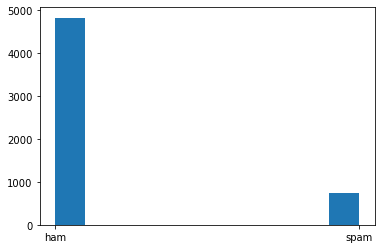

In [20]:
#Let's look at the distribution of labels:
fig = plt.hist(df['target']) 
plt.show()

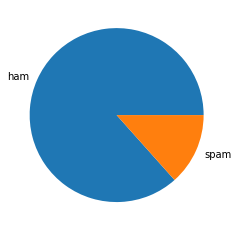

In [29]:
fig = plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], normalize=True)
plt.show()

In [30]:
#The spam makes up 13.4% of the dataset while ham composes 86.6% of the dataset.

### The length of the messages might provide some insights. 

In [31]:
df['length'] = df['message'].apply(len)
df.head()

,target,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


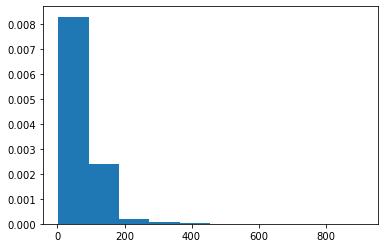

In [42]:
fig = plt.hist(df['length'].loc[df['target']=='ham'], density=True)
plt.show()

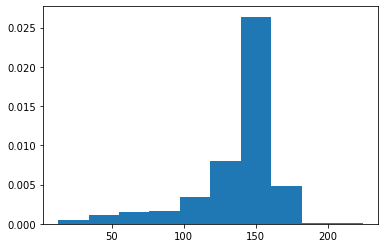

In [43]:
fig = plt.hist(df['length'].loc[df['target']=='spam'], density=True)
plt.show()

It can be seen that ham messages are shorter than spam messages as the distribution of ham and spam message lengths are centered around 30-40 and 155-160 characters, respectively.

### Creating a word cloud 

Having a view of the most common words used in spams and hams will help us understand the dataset better. A word cloud can give you an idea of what kind of words are dominant in each class.
To make a word cloud, first separate the classes into two pandas data frames and add a simple word cloud function, as shown below:

In [45]:
data_ham  = df[df['target'] == "ham"].copy()
data_spam = df[df['target'] == "spam"].copy()

def show_wordcloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#ffa78c",
                                        width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

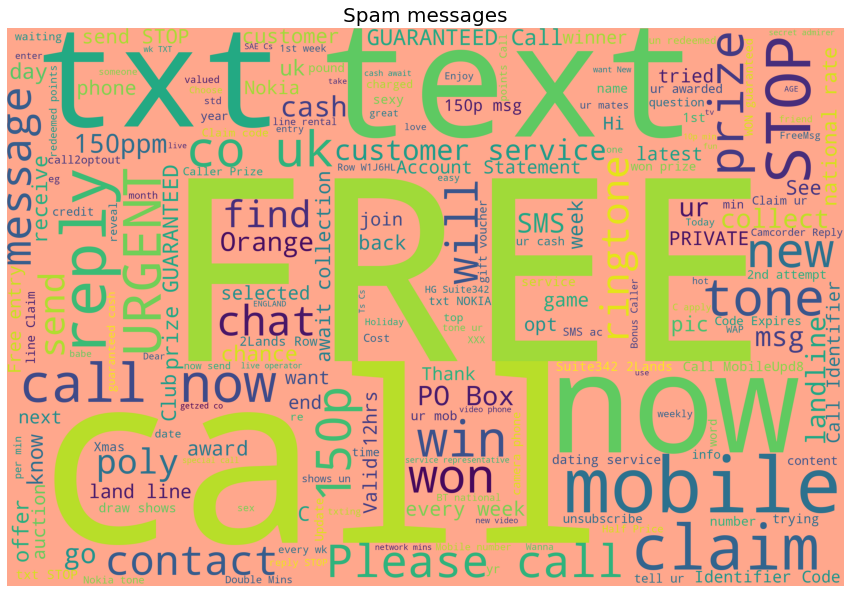

In [46]:
show_wordcloud(data_spam, "Spam messages")

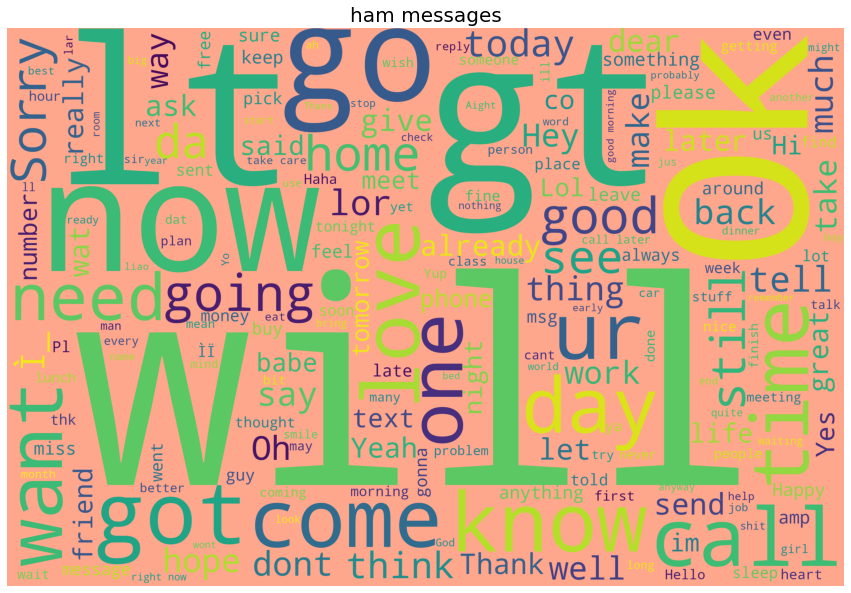

In [47]:
show_wordcloud(data_ham, "ham messages")

# Preprocess the Data
The process of converting data to something a computer can understand is referred to as pre-processing. 

### First, we’ll convert the label to numeric form.

In [48]:
df['target'] = df['target'].map( {'spam': 1, 'ham': 0})

### Next, we will process the message content with Regular Expressions (Regex) to keep email and web addresses, phone numbers, and numbers uniform, encode symbols, remove punctuation and white spaces, and finally convert all text to lowercase:

In [49]:
# Replace email address with 'emailaddress'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['message'] = df['message'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['message'] = df['message'].str.lower()

In [52]:
df['message'].head(10)

0    go until jurong point crazy available only in ...
1                            ok lar joking wif u oni  
2    free entry in number a wkly comp to win fa cup...
3        u dun say so early hor u c already then say  
4    nah i don t think he goes to usf he lives arou...
5    freemsg hey there darling it s been number wee...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile number months or more u r enti...
Name: message, dtype: object

Going forward, we'll remove stopwords from the message content. Stop words are words that search engines have been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query

### Remove stopwords

In [56]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [58]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['message'] = df['message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

### Stemming

Next, we will extract the base form of words by removing affixes from them. This called stemming, as it can be illustrated as cutting down the branches of a tree to its stems. There are numerous stemming algorithms, such as:
Porter’s Stemmer algorithm. Here Snowball Stemmer was utilized due to its computational speed.

Note: When using these stemming algorithms, be careful not to over-stem or under-stem.

In [59]:
ss = nltk.SnowballStemmer("english")
df['message'] = df['message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))

Machine learning algorithms cannot work with raw text directly. The text must be converted into numbers—more specifically, vectors of numbers. Let's split the messages (text data in sentences) into words. This is a requirement in natural language processing tasks where each word needs to be captured and subjected to further analysis. First, we create a Bag of Words (BOW) model to extract features from text:

### Tokenize

In [61]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [62]:
sms_df = df['message']
from nltk.tokenize import word_tokenize

# creating a bag-of-words model
all_words = []
for sms in sms_df:
    words = word_tokenize(sms)
    for w in words:
        all_words.append(w)

"""
A frequency distribution for the outcomes of an experiment.  A
frequency distribution records the number of times each outcome of
an experiment has occurred.
"""
all_words = nltk.FreqDist(all_words)

### Look at total and most common words

In [63]:
#Let's take a look at the total number of words:
print('Number of words: {}'.format(len(all_words)))

Number of words: 6526


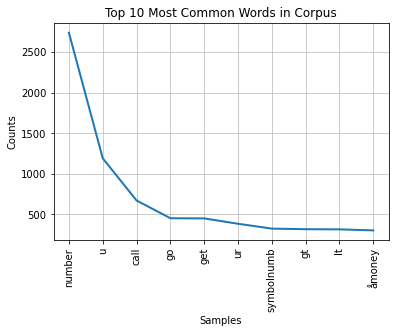

<AxesSubplot:title={'center':'Top 10 Most Common Words in Corpus'}, xlabel='Samples', ylabel='Counts'>

In [64]:
#Now plot the top 10 common words in the text data:

all_words.plot(10, title='Top 10 Most Common Words in Corpus')

### TF-IDF

Next, we will implement an NLP technique—term frequency-inverse document frequency—to evaluate how important words are in the text data. In short, this technique simply defines what a “relevant word” is. The tfidf_model created from this NLP technique will be saved (serialized) to the local disk for transforming the test data for our web application later:

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(sms_df)

import pickle
#serializing our model to a file called model.pkl
pickle.dump(tfidf_model, open("tfidf_model.pkl","wb"))

In [68]:
tfidf_data=pd.DataFrame(tfidf_vec.toarray())
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,...,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
tfidf_data.shape

(5572, 6506)

## Split data into train-test-val set

In order to train and validate the performance of our machine learning model, we need to split the data into training and test dataset respectively. The training set should be later split into a train and validation set.

In [72]:
### Separating Columns
df_train = tfidf_data.iloc[:4457]
df_test = tfidf_data.iloc[4457:]

target = df['target']
df_train['target'] = target

Y = df_train['target']
X = df_train.drop('target',axis=1)

# splitting training data into train and validation using sklearn
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.2, random_state=42)

We will be utilizing a machine learning algorithm known as LightGBM. It is a gradient boosting framework that uses tree based learning algorithms. It has the following benefits:

    Faster training speed and higher efficiency
    Lower memory usage
    Better accuracy
    Support of parallel and GPU learning
    Capable of handling large-scale data

The performance metric for this project is the F1 score. This metric considers both precision and recall to compute the score. The F1 score reaches its best value at 1 and worst value at 0.

## Apply Various algorithms

In [75]:
import lightgbm as lgb
from sklearn.metrics import f1_score

def train_and_test(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f'F1 score is: {f1_score(pred, y_test)}')
    
for depth in [1,2,3,4,5,6,7,8,9,10]:
    lgbmodel = lgb.LGBMClassifier(max_depth=depth, n_estimators=200, num_leaves=40)
    print(f"Max Depth {depth}")
    print(" ")
    print(" ")
    train_and_test(lgbmodel, "Light GBM")

Max Depth 1
 
 
F1 score is: 0.8870292887029289
Max Depth 2
 
 
F1 score is: 0.9236947791164659
Max Depth 3
 
 
F1 score is: 0.9149797570850203
Max Depth 4
 
 
F1 score is: 0.912
Max Depth 5
 
 
F1 score is: 0.9133858267716536
Max Depth 6
 
 
F1 score is: 0.9098039215686274
Max Depth 7
 
 
F1 score is: 0.9133858267716536
Max Depth 8
 
 
F1 score is: 0.9169960474308301
Max Depth 9
 
 
F1 score is: 0.9206349206349207
Max Depth 10
 
 
F1 score is: 0.9206349206349207


From this iteration, it can be seen that the Max Depth of six (10) has the highest F1 score of 0.9285714285714285. We will further perform a random grid search for the best parameters for the model:

### Randomized CV search for finding best hyperparameters

In [82]:
# from sklearn.model_selection import RandomizedSearchCV
# lgbmodel_bst = lgb.LGBMClassifier(max_depth=4, n_estimators=100, num_leaves=40)
# param_grid = {
#     'num_leaves': list(range(8, 92, 4)),
#     'min_data_in_leaf': [10, 20, 40, 60, 100],
#     'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
#     'learning_rate': [0.1, 0.05, 0.01, 0.005],
#     'bagging_freq': [3, 4, 5, 6, 7],
#     'bagging_fraction': np.linspace(0.6, 0.95, 10),
#     'reg_alpha': np.linspace(0.1, 0.95, 10),
#     'reg_lambda': np.linspace(0.1, 0.95, 10),
#     "min_split_gain": [0.0, 0.1, 0.01],
#     "min_child_weight": [0.001, 0.01, 0.1, 0.001],
#     "min_child_samples": [20, 30, 25],
#     "subsample": [1.0, 0.5, 0.8],
# }
# model = RandomizedSearchCV(lgbmodel_bst, param_grid, random_state=1)
# search = model.fit(X_train, y_train)
# search.best_params_

### Train model with best parameters

In [81]:
#We'll use the best parameters to the train the model:

best_model = lgb.LGBMClassifier(subsample=0.5,
                            reg_lambda= 0.47777777777777775,
                            reg_alpha= 0.5722222222222222,
                            num_leaves= 88,
                            min_split_gain= 0.01,
                            min_data_in_leaf= 10,
                            min_child_weight= 0.01,
                            min_child_samples= 30,
                            max_depth= 3,
                            learning_rate= 0.1,
                            bagging_freq= 3,
                            bagging_fraction= 0.6,
                            random_state=1)
best_model.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=3, max_depth=3,
               min_child_samples=30, min_child_weight=0.01, min_data_in_leaf=10,
               min_split_gain=0.01, num_leaves=88, random_state=1,
               reg_alpha=0.5722222222222222, reg_lambda=0.47777777777777775,
               subsample=0.5)

### Model Evaluation

In [83]:
#Let's check the performance of the model by its prediction:

prediction = best_model.predict(X_test)
print(f'F1 score is: {f1_score(prediction, y_test)}')

F1 score is: 0.891566265060241


#### As a last step, we'll do a full training on the dataset so our web app can make predictions for data it hasn't seen.  We'll save the model to our local machine:

In [84]:
best_model.fit(tfidf_data, target)
pickle.dump(best_model, open("spam_model.pkl","wb"))

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


# Embed the Model in a Flask Application

https://learn.vonage.com/blog/2020/11/19/sms-spam-detection-with-machine-learning-in-python/

Now that you have the trained model, we are going to create a **Flask application that will read messages sent and received via the Vonage SMS API and classify** them into spam or ham. The final result will be displayed in an SMS dashboard

With that, we come to the end of this tutorial. You can try other SMS examples to see the outcome. I’m sure you can already think of all the amazing possibilities and use cases of this new knowledge. You can integrate this spam filtering into ***HR software, chatbots, customer service, and any other message-based application.***